In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np

import time

In [2]:
%matplotlib inline

In [3]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

In [4]:
def boxcox_feature(feature_name, df):
    import scipy.stats as spstats
    feature_np = np.array(df[feature_name])
    feature_np_clean = feature_np[~np.isnan(feature_np)]
    l, opt_lambda = spstats.boxcox(feature_np_clean)
    df[feature_name+'_0'] = spstats.boxcox(
                                        (1+df[feature_name]), 
                                          lmbda=0)
    df[feature_name+'_0'] = df[feature_name+'_0'].fillna(0.0)
    df[feature_name+'_boxcox_lambda_opt'] = spstats.boxcox(
                                            df[feature_name], lmbda = opt_lambda)
    df[feature_name+'_boxcox_lambda_opt'] = df[feature_name+'_boxcox_lambda_opt'].fillna(0.0)
    return df

def transfrom_numerical(df):
    features_numerical = ['GuaranteeValueLot', 'StepDecreaseLot', 'SumTender']
    for feature in features_numerical:
        df[feature] = df[feature].apply(pd.to_numeric, errors='coerce')
    df[features_numerical] = df[features_numerical].fillna(0)
    for feature in features_numerical:
        df[feature+'_isZero'] = df[feature].apply(lambda x: 1 if x==0.0 else 0)
    df[features_numerical] = df[features_numerical].replace(0.0, np.nan)
    for feature in features_numerical:
        df = boxcox_feature(feature, df)
    df = df.drop(columns=features_numerical)
    return df

In [5]:
def strip(x, n):
    return x.strip()[:n].strip()

def add_CPV_features(df, split_type=1):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['CPV2017'] = df['CPV2017'].apply(lambda x: '00000000-0' if strip(x, 10) == '-' else x)
    
    if split_type == 1:
        df['CPV_unit'] = df['CPV2017'].apply(lambda x: int(x.strip()[:2]))
        df['CPV_group'] = df['CPV2017'].apply(lambda x: int(x.strip()[2:3]))
        df['CPV_class'] = df['CPV2017'].apply(lambda x: int(x.strip()[3:4]))
        df['CPV_cat'] = df['CPV2017'].apply(lambda x: int(x.strip()[4:5]))
    else:
        df['CPV_unit'] = df['CPV2017'].apply(lambda x: int(x.strip()[:2]))
        df['CPV_group'] = df['CPV2017'].apply(lambda x: int(x.strip()[:3]))
        df['CPV_class'] = df['CPV2017'].apply(lambda x: int(x.strip()[:4]))
        df['CPV_cat'] = df['CPV2017'].apply(lambda x: int(x.strip()[:5]))
    
    df['CPV_desc'] = df['CPV2017'].apply(lambda x: x[11:])
    df['CPV_desc'] = df['CPV_desc'].apply(lambda x: "NO DESC" if len(x.strip()) < 2 else x )
    
    df['Organizer'] = df['Organizer'].apply(lambda x: x.lower())
    df['Organizer_railroad'] = df['Organizer'].apply(lambda x: 1 if 'залізниц' in x else 0)
    df['Organizer_ministry'] = df['Organizer'].apply(lambda x: 1 if 'міністерств' in x else 0)
    df['Organizer_komun'] = df['Organizer'].apply(lambda x: 1 if 'комунальне підприємство' 
                                                  in x else 0)
    df['Organizer_edu'] = df['Organizer'].apply(lambda x: 1 if 'освіт' in x else 0)
    
    return df

In [6]:
df_train_grouped = pd.read_csv('../data/train_grouped_fred.csv')
df_test = pd.read_csv('../data/test_fred.csv')

In [7]:
print(df_train_grouped.shape, df_test.shape)

(500037, 47) (75969, 45)


In [8]:
df_train_grouped = df_train_grouped[df_train_grouped['LotStatus'] == 
         'Завершено лот закупівлі'][df_train_grouped['TenderStatus'] == 
                                    'complete']

/home/dima/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df_train_grouped = transfrom_numerical(df_train_grouped)

/home/dima/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1030: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


In [10]:
df_train_grouped = add_CPV_features(df_train_grouped)

In [11]:
df_train_grouped['counts'] = df_train_grouped['counts'].apply(lambda x: np.log1p(x))

In [12]:
categorical_columns = [c for c in df_train_grouped.columns if df_train_grouped[c].dtype.name == 'object']
numerical_columns   = [c for c in df_train_grouped.columns if df_train_grouped[c].dtype.name != 'object']
print('*'*30)
print('Categorical columns:')
print()
print('\n'.join(categorical_columns))
print('*'*30)
print('Numerical columns:')
print()
print('\n'.join(numerical_columns))

******************************
Categorical columns:

unique_id
CPV2017
Organizer
ID
IDLOT
StartOfferDate
LotStatus
TenderStatus
Tender
StartDateCorrection
LotDescr
EndDate
EndOfferDate
train_val
CPV_desc
******************************
Numerical columns:

TypeMethod
TypeOrginizer
IDOrganizator
counts
DeliveryRegion
OrgRegion
OrgRegion_lat
OrgRegion_long
DeliveryRegion_lat
DeliveryRegion_long
DeliveryOrg_isequal
DeliveryOrg_distance
CPV_unit
CPV_group
CPV_class
CPV_cat
Organizer_railroad
Organizer_ministry
Organizer_komun
Organizer_edu
GuaranteeValueLot_isZero
StepDecreaseLot_isZero
SumTender_isZero
GuaranteeValueLot_0
GuaranteeValueLot_boxcox_lambda_opt
StepDecreaseLot_0
StepDecreaseLot_boxcox_lambda_opt
SumTender_0
SumTender_boxcox_lambda_opt


In [13]:
drop_features = ['unique_id', 'CPV2017', 'Organizer', 'ID', 'IDLOT', 'StartOfferDate', 
                 'LotStatus', 'TenderStatus', 'Tender', 'StartDateCorrection', 'LotDescr', 
                 'EndDate', 'EndOfferDate', 'CPV_desc', 'counts', 'train_val', 
                'DeliveryRegion_lat', ]

In [14]:
features = []

features += ['TypeMethod', 'TypeOrginizer']

features += ['OrgRegion', 'DeliveryRegion']
features += ['DeliveryOrg_isequal']
features += ['DeliveryOrg_distance']

features += ['GuaranteeValueLot_isZero', 'StepDecreaseLot_isZero',
       'SumTender_isZero']
features += ['GuaranteeValueLot_0', 'StepDecreaseLot_0', 'SumTender_0']
# features = ['GuaranteeValueLot_boxcox_lambda_opt', 'StepDecreaseLot_boxcox_lambda_opt', 'SumTender_boxcox_lambda_opt']

features += ['Organizer_railroad', 'Organizer_ministry', 'Organizer_komun', 'Organizer_edu']
features += ['CPV_unit', 'CPV_group', 'CPV_class','CPV_cat']

In [15]:
train = df_train_grouped[df_train_grouped.train_val=='train']
val = df_train_grouped[df_train_grouped.train_val=='val']

In [16]:
x_train = train[features]
y_train = train['counts']

x_test = val[features]
y_test = val['counts']

In [17]:
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

def xgb_rmsle(y_true, y_pred):
    
    if isinstance(y_pred, xgb.core.DMatrix):
        y_pred = y_pred.get_label()
    if isinstance(y_true, xgb.core.DMatrix):
        y_true = y_true.get_label()

    y_true = y_true.tolist()
    y_pred = y_pred.tolist()

    assert len(y_true) == len(y_pred)

    return 'rmsle', rmsle(y_true, y_pred)

In [18]:
from sklearn.metrics import r2_score
def xgb_r2_score(y_true, y_pred):
    if isinstance(y_pred, xgb.core.DMatrix):
        y_pred = y_pred.get_label()

    y_true = y_true.tolist()
    y_pred = y_pred.tolist()

    assert len(y_true) == len(y_pred)

    return 'r2_score', r2_score(y_true, y_pred)

In [19]:
def train_xgb_regressor(X_train, X_val, y_train, y_val):
    start_time = time.time()
    dtrain = xgb.DMatrix(X_train, y_train)
    dval = xgb.DMatrix(X_val, y_val)

    watchlist = [(dtrain, 'train'), (dval, 'val')]

    # Uncomment to tune XGB `num_boost_rounds`
    model = xgb.train(params=XGB_PARAMS, dtrain=dtrain,
                      num_boost_round=1000,
                      evals=watchlist,
#                       feval=xgb_rmsle,
                      maximize=True,
                      early_stopping_rounds=50,
                      verbose_eval=10)
    print(f"XGB model has been trained in {time.time()-start_time:.2f} seconds")
    return model

In [96]:
XGB_PARAMS = {
    'eta': 0.42,
    'max_depth': 6, # better 6
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [97]:
model = train_xgb_regressor(x_train, x_test, y_train, y_test)

[0]	train-rmse:0.515222	val-rmse:0.488202
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.351661	val-rmse:0.3295
[20]	train-rmse:0.347419	val-rmse:0.327789
[30]	train-rmse:0.344717	val-rmse:0.3274
[40]	train-rmse:0.343127	val-rmse:0.327389
[50]	train-rmse:0.341922	val-rmse:0.32744
Stopping. Best iteration:
[0]	train-rmse:0.515222	val-rmse:0.488202

XGB model has been trained in 4.33 seconds


In [98]:
y_pred = model.predict(xgb.DMatrix(x_test))

In [99]:
def rmsle_fred(y_true,y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [100]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, y_pred))
# rms = rmsle_fred(y_test,y_pred)

In [101]:
rms

0.3274397719723322

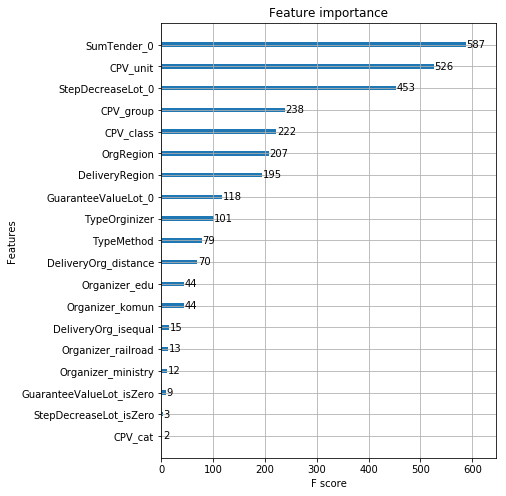

In [41]:
my_plot_importance(model, (6,8))

In [27]:
df_test = transfrom_numerical(df_test)

/home/dima/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1030: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


In [28]:
df_test = add_CPV_features(df_test)

In [29]:
df_test[features].shape

(75969, 20)

In [30]:
final_preds = model.predict(xgb.DMatrix(df_test[features]))

In [31]:
df_test['target'] = np.exp(final_preds) - 1

In [32]:
df_test.reset_index()[['unique_id','target']].to_csv('xgb_submission.csv', index=False)

In [33]:
ss = pd.read_csv('xgb_submission.csv')

In [34]:
ss.shape

(75969, 2)